<a href="https://colab.research.google.com/github/martinaluyten/Analysis-of-Big-Data-in-Physics/blob/main/Gravitational_wave_data_analysis_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational wave data analysis: Detector noise

# Assignment 2

In [ ]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

In [24]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np

from pycbc.waveform import td_approximants, fd_approximants
import pylab
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.conversions import mass1_from_mchirp_q

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


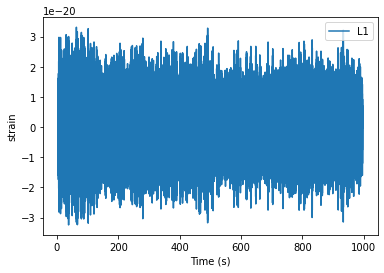

In [26]:
#Loading the data of the LIGO Hanford detector 
d=np.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy')
dt=d[:,0]
#comverting data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
strain, stilde = {}, {}

strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)
strain['L1'] = strain['L1'].crop(4, 4)

#frequency domain version of the data
stilde['L1'] = strain['L1'].to_frequencyseries()

#pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

# power spectral density of that data

(1e-47, 1e-42)

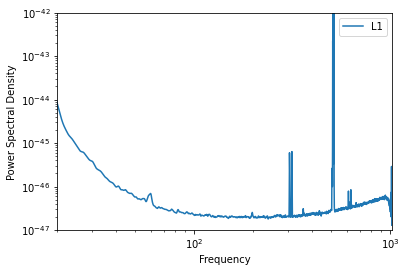

In [27]:
#controling the data that will be corrupted by overwhitening the data : chosing 2seconds
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
psds={}
psds['L1'] = interpolate(strain['L1'].psd(2),stilde['L1'].delta_f)
#psd=strain['L1'].psd(4)
#psds['L1']=interpolate(strain['L1'].psd(2),stilde['L1'].delta_f)
#psds['L1'] = interpolate(welch(strain['L1']), 1.0 / strain['L1'].duration)
#psd = interpolate(psd, strain['L1'].delta_f)
psds['L1']=inverse_spectrum_truncation(psds['L1'],int(2*strain['L1'].sample_rate),
                                                        low_frequency_cutoff=15.0,
                                                        trunc_method='hann')
pylab.loglog(psds['L1'].sample_frequencies,psds['L1'],label='L1')
pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
pylab.legend()

pylab.xlim(20,1024)
pylab.ylim(1e-47,1e-42)

**calculating matched filter**

In [28]:
#calculating matched filter to test whether there is any gravitational wave signal present in the data
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pyparsing.helpers import MatchFirst
import pandas as pd
f_low=20
masses=np.arange(5,10,0.1)
snrs={}

#template waveforms with mass ranges between 5 to 10 with equal mass binary systems
for m in masses:
  hp, hc=get_fd_waveform(approximant='TaylorF2',
                         mass1=m,mass2=m,
                         f_lower=15,
                         delta_f=stilde['L1'].delta_f) #1.0/stilde['L1'].duration
  hp.resize(len(stilde['L1']))
  template=hp.cyclic_time_shift(hp.start_time)
  #psd.resize(len(stilde['L1'])) 
  snr=matched_filter(template,strain['L1'],psd=psds['L1'],low_frequency_cutoff=15.0)
  snr=snr.crop(4+4,4)


#tlen=len(stilde['L1'])
 # hp.resize(tlen)
  #flow=20
  #delta_f = 1.0/stilde['L1'].duration
  #flen=tlen//2+1
  #psd=aLIGOZeroDetHighPower(flen,delta_f,f_low)

  #snr=matched_filter(hp,stilde['L1'],psd=psd,low_frequency_cutoff=20)



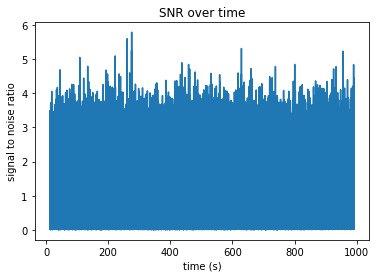

Maximum SNR 5.786891962082004


In [29]:
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal to noise ratio')
pylab.xlabel('time (s)')
pylab.title("SNR over time")
pylab.show()
print ( 'Maximum SNR', max(abs(snr)) )

Maximum SNR(signal to noise ratio) doesn't crosses 8 therefore the data corresponds to only noise.

**Gaussian distribution***

In [30]:
##whitening the data
import pycbc.psd
white_data=((stilde['L1']/psds['L1'])**0.5).to_timeseries()
white_data=white_data.crop(4,4)

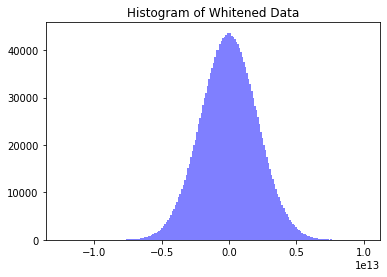

In [31]:
#plotting histogram of the whitened data
num_bins = 200
n, bins, patches = plt.hist(white_data, num_bins, facecolor='blue', alpha=0.5)
plt.title("Histogram of Whitened Data")
plt.show()

we can see that the distribution is a Gaussian distribution with zero mean.

**stationary assumption: noise is stationary Gaussian:**

testing whether the noise follows the stationary assumption

In [32]:
#generating a frequency domain waveform
hp, hc=get_fd_waveform(approximant='TaylorF2',
                       mass1=3,mass2=3,
                       delta_f=1/200,
                       distance=500,
                       f_lower=20,f_final=2048)

In [33]:
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d

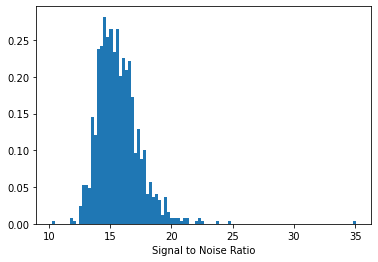

In [34]:
snr_list = []

#dividing data into equal time intervals
chunck = (int)(len(data)/1000)
delta_f=1.0/(200)

#estimating the psd from each chunks for data
for index in range(1000):
 
  data_chuncks = data[index*chunck : (index+1)*chunck]
  psd_list = interpolate(welch(data_chuncks), delta_f)
  snr = (pycbc.filter.sigmasq(hp, psd_list))**0.5
  
  snr_list.append(snr)

#histogram out of the estimated SNR
plt.hist(snr_list, 100, density=True)
pylab.xlabel('Signal to Noise Ratio')
pylab.show()  

If the noise was Gaussian Statiionary a mean of 0 would be expected on the avove histograms of the SNR of the individual chunks. This shows that the stationary assumption that the noise is stationary Gaussian does not hold.